## Redes Convolucionales: Ejemplo clasificación de perros y gatos

En este notebook utilizaremos datos de la [competición de Kaggle Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview), a partir de los cuales intentaremos crearnos un sistema capaz de diferenciar entre perros y gatos mediante redes neuronales.

Podrás acceder a la carpeta con las imágenes directamente desde el siguiente enlace a Google Drive: https://drive.google.com/drive/u/0/folders/1oVWZ2-2Whwiw9gFvR-aqQ4Y5sbDzYUtd

# Importamos librerías

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Definimos constantes

Vamos a definir una serie de variables que se mantendrán constantes a lo largo de la ejecución del notebook, como tamaño de las imágenes que vamos a utilizar para analizarlas o el número de epochs que vamos a utilizar:

In [33]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_CHANNELS=3
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 64
EPOCHS = 5

# DATA_PATH = "dogs-vs-cats/mini_data/"
DATA_PATH = "dogs-vs-cats/train/"

In [3]:
DATA_PATH

'dogs-vs-cats/train/'

In [4]:
len(os.listdir(DATA_PATH))

25000

# Preparación de los datos
1. Descárgate el dataset de train de [la competición de Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview) o del [enlace](https://drive.google.com/drive/u/0/folders/1oVWZ2-2Whwiw9gFvR-aqQ4Y5sbDzYUtd) a Google Drive (si no te quieres registrar y todo eso).
2. Descomprime el dataset y guárdalo en la ruta actual, de modo que te queden las carpetas:

```
2-Redes Convolucionales:
   * dogs-vs-cats:
       * train
           * fotos
       * test
           * fotos
       
```  

In [5]:
DATA_PATH

'dogs-vs-cats/train/'

In [6]:
filenames = os.listdir(DATA_PATH)

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filenames': filenames,
    'category': categories
})

In [7]:
df

,filenames,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


## Representación de la distribución de las categorías

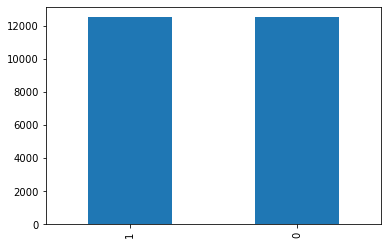

In [8]:
df['category'].value_counts().plot.bar();

## Representamos las imágenes

In [10]:
# !pip install opencv-python

(499, 290, 3)
255


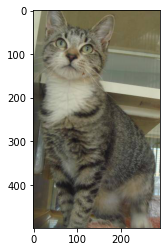

In [15]:
from skimage.io import imread
import cv2

sample = random.choice(filenames)

image = imread(DATA_PATH + sample)
print(image.shape)
print(np.max(image))
plt.imshow(image);

Una imagen no es mas que un array de HxWxC píxeles, siendo H(Height) y W(Width) las dimensiones de resolución de la imagen, y C el número de canales. Habrá tres valores por píxel. 

In [16]:
image

array([[[199, 202, 181],
        [199, 202, 181],
        [199, 202, 181],
        ...,
        [112, 106,  74],
        [117, 107,  72],
        [117, 107,  72]],

       [[199, 202, 181],
        [199, 202, 181],
        [199, 202, 181],
        ...,
        [112, 106,  74],
        [114, 104,  69],
        [114, 104,  69]],

       [[200, 203, 182],
        [200, 203, 182],
        [200, 203, 182],
        ...,
        [112, 106,  74],
        [114, 104,  69],
        [114, 104,  69]],

       ...,

       [[ 60,  61,  47],
        [ 59,  60,  46],
        [ 57,  57,  45],
        ...,
        [142,  86,  73],
        [140,  84,  71],
        [143,  87,  74]],

       [[ 60,  61,  47],
        [ 59,  60,  46],
        [ 57,  57,  45],
        ...,
        [140,  84,  71],
        [139,  83,  70],
        [142,  86,  73]],

       [[ 60,  61,  47],
        [ 59,  60,  46],
        [ 57,  57,  45],
        ...,
        [137,  81,  68],
        [137,  81,  68],
        [140,  84,  71]]

# Redimensionando imagen

Cargar todas las imágenes a la vez es un problema, ya que son un total de 25000 (unos 500MB la carpeta de train). Este proceso require mucha memoria, por lo que tendremos que aplicarle un resize a cada imagen para bajarlas de resolución. Esto también nos sirve para solventar el problema de tener imágenes con distintas resoluciones.

Tamaño imagen original: (323, 432, 3)
Tamaño imagen reshape: (64, 64, 3)
Maximo valor por pixel: 255


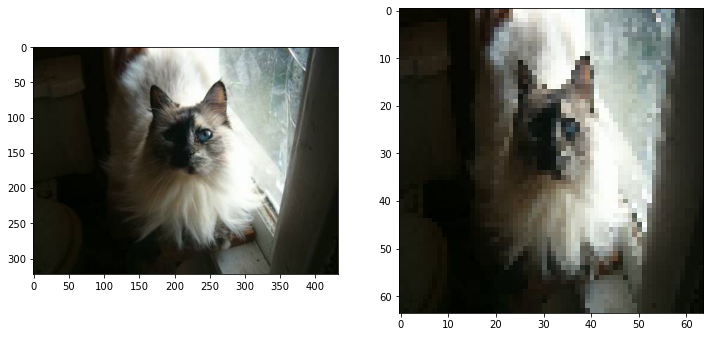

In [17]:
plt.figure(figsize=(12, 12))

sample = random.choice(filenames)
image = imread(DATA_PATH + sample)
imagesmall = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", imagesmall.shape)
print("Maximo valor por pixel:", np.max(imagesmall))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(imagesmall);

# Color
Podríamos cargar las imágenes como blanco y negro, de esta forma se reduciría el espacio de features considerablemente al contar con un único canal

(336, 250)


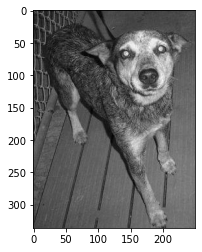

In [18]:
sample = random.choice(filenames)
image = cv2.imread(filename=DATA_PATH + sample,
                   flags=cv2.IMREAD_GRAYSCALE)
print(image.shape)
plt.imshow(image, cmap='gray');

# Cargamos los datos

Llega el momento de cargar los datos. Ya no es tan sencillo como cuando teníamos datasets en CSVs puesto que ahora hay que cargar miles de archivos en memoria en este notebook. Para ello necesitaremos un programa iterativo que vaya recorriendo los archivos de la carpeta, cargarlos como array de numpy y almacenarlos en un objeto.

In [19]:
from sklearn.model_selection import train_test_split

def read_data(path):
    X = []
    Y = []

    for file in os.listdir(path):
        image = imread(path + file)
        smallimage = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        X.append(smallimage)
        
        category = file.split('.')[0]
    
        if category == 'dog':
            Y.append(1)
        else:
            Y.append(0)

    return np.array(X), np.array(Y)
    

X_train_full, y_train_full = read_data(DATA_PATH)

X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(20000, 64, 64, 3)
(5000, 64, 64, 3)


In [20]:
DATA_PATH

'dogs-vs-cats/train/'

(64, 64, 3)


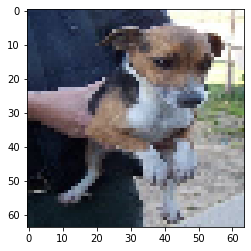

In [35]:
print(X_train[0].shape)
plt.imshow(X_train[0]);

In [21]:
X_train[0]

array([[[ 21,  15,  15],
        [ 21,  15,  15],
        [ 16,  15,  16],
        ...,
        [ 70,  38,  16],
        [ 64,  35,  19],
        [ 58,  34,  20]],

       [[ 21,  15,  15],
        [ 20,  14,  14],
        [ 21,  16,  21],
        ...,
        [ 66,  37,  18],
        [ 60,  35,  22],
        [ 56,  34,  23]],

       [[ 26,  19,  19],
        [ 22,  16,  16],
        [ 25,  18,  25],
        ...,
        [ 64,  38,  21],
        [ 58,  36,  23],
        [ 48,  30,  21]],

       ...,

       [[ 86,  62,  47],
        [ 77,  47,  33],
        [ 91,  63,  49],
        ...,
        [ 97,  83,  74],
        [ 88,  76,  67],
        [ 47,  34,  25]],

       [[ 85,  61,  45],
        [ 82,  53,  34],
        [ 82,  57,  41],
        ...,
        [102,  88,  79],
        [ 95,  87,  77],
        [ 90,  83,  75]],

       [[ 83,  58,  42],
        [ 85,  56,  35],
        [ 80,  57,  39],
        ...,
        [ 96,  82,  73],
        [ 99,  90,  80],
        [ 97,  87,  83]]

# Normlizando los datos

Normalizar los datos hará que entrene mucho mejor la red, al estar todos los pixeles en la misma escala.

In [22]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0
Max: 255


In [23]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.0
Max: 1.0


# Guardando los datos

Podemos guardar los arrays de numpy en un archivo `.npz`, de tal manera que luego sea más rápido importarlo

In [25]:
np.savez('data.npz',
         X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Para cargar:

In [26]:
data = np.load('data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

# Modelo

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Conv Layer**: extraerá diferentes features de las imagenes
* **Pooling Layer**: Reduce las dimensiones de las imágenes tras una capa convolucional
* **Fully Connected Layer**: Tras las capas convolucionales, aplanamos las features y las introducimos como entrada de una red neuronal normal.
* **Output Layer**: Las predicciones de la red

Para el loss y la métrica, se puede usar un binary_crossentropy, al ser un target binario:

In [29]:
from tensorflow import keras

layers = [
    # 64 filtros
    # (3,3) kernel de la convolucion
    keras.layers.Conv2D(64,
                        (3,3),
                        activation='relu',
                        input_shape=IMAGE_SIZE),
    
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64,
                       (3,3),
                       activation='relu'),
    
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    # Fully connected layer
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
]

model = keras.Sequential(layers)

# loss para n clases (cambiar output) seria sparse_categorical_crossentropy
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                802880    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

# Callbacks
#### Early Stopping

In [31]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=10)

# Entranando el modelo

In [34]:
model.fit(X_train,
         y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         #callbacks=[earlystop],
         validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 70s 280ms/step - loss: 0.5925 - accuracy: 0.6862 - val_loss: 0.5861 - val_accuracy: 0.6940
Epoch 2/5
250/250 [==============================] - 71s 283ms/step - loss: 0.5626 - accuracy: 0.7096 - val_loss: 0.5457 - val_accuracy: 0.7230
Epoch 3/5
250/250 [==============================] - 73s 290ms/step - loss: 0.5036 - accuracy: 0.7527 - val_loss: 0.5092 - val_accuracy: 0.7567
Epoch 4/5
250/250 [==============================] - 71s 286ms/step - loss: 0.4391 - accuracy: 0.7945 - val_loss: 0.4772 - val_accuracy: 0.7755
Epoch 5/5
250/250 [==============================] - 68s 272ms/step - loss: 0.3826 - accuracy: 0.8289 - val_loss: 0.4832 - val_accuracy: 0.7857


Guardamos el histórico:

In [35]:
history = model.history.history

# Evalúa los resultados

Probemos los datos en el conjunto de test:

In [36]:
results = model.evaluate(X_test, y_test)
print("test loss, test acc", results)

157/157 [==============================] - 6s 36ms/step - loss: 0.4922 - accuracy: 0.7754
test loss, test acc [0.49217793345451355, 0.7753999829292297]


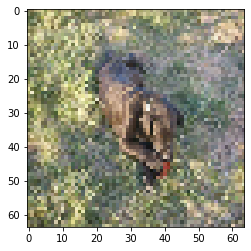

In [37]:
plt.imshow(X_test[1000]);

In [38]:
y_test[1000]

1

In [39]:
X_test[1000:1001]

array([[[[0.47843137, 0.47843137, 0.35294118],
         [0.54117647, 0.49019608, 0.33333333],
         [0.71372549, 0.6627451 , 0.48627451],
         ...,
         [0.85882353, 0.73333333, 0.65882353],
         [0.60784314, 0.55294118, 0.4745098 ],
         [0.59215686, 0.55686275, 0.48235294]],

        [[0.47843137, 0.50980392, 0.37254902],
         [0.36078431, 0.37254902, 0.22352941],
         [0.37647059, 0.42352941, 0.28627451],
         ...,
         [0.69411765, 0.62745098, 0.61960784],
         [0.68235294, 0.63921569, 0.50588235],
         [0.76862745, 0.67058824, 0.52941176]],

        [[0.35294118, 0.40392157, 0.25882353],
         [0.30980392, 0.37254902, 0.23137255],
         [0.49803922, 0.51764706, 0.39607843],
         ...,
         [0.49019608, 0.48627451, 0.47058824],
         [0.67058824, 0.68235294, 0.47843137],
         [0.68235294, 0.67058824, 0.51372549]],

        ...,

        [[0.35686275, 0.3372549 , 0.13333333],
         [0.36862745, 0.40784314, 0.2745098 ]

In [41]:
predictions = model.predict(X_test[1000:1001]).round(2)
print("prections shape:", predictions.shape)
predictions

prections shape: (1, 1)


array([[0.89]], dtype=float32)

# Visualizando el rendimiento

Utilizaremos los datos históricos guardados previamente:

In [42]:
history

{'loss': [0.5925166010856628,
  0.5626395344734192,
  0.5036411285400391,
  0.4390795826911926,
  0.3826158046722412],
 'accuracy': [0.6862499713897705,
  0.7096250057220459,
  0.7526875138282776,
  0.7944999933242798,
  0.8289374709129333],
 'val_loss': [0.5861344933509827,
  0.5457173585891724,
  0.509171724319458,
  0.4772021472454071,
  0.4831750988960266],
 'val_accuracy': [0.6940000057220459,
  0.7229999899864197,
  0.7567499876022339,
  0.7754999995231628,
  0.7857499718666077]}

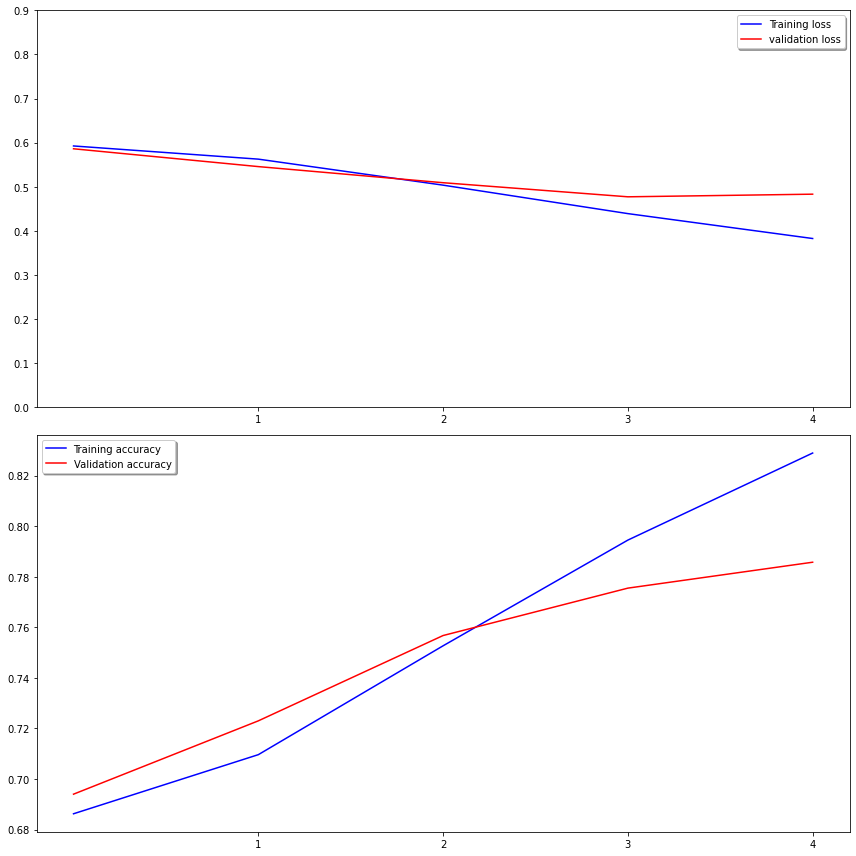

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history['loss'], color='b', label="Training loss")
ax1.plot(history['val_loss'], color='r', label="validation loss")
ax1.legend(loc='best', shadow=True)
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()